# Spectral Sampling with pyrff

[Pyrff](https://github.com/michaelosthege/pyrff) is a library that implements spectral sampling. I want to see if I can get it to work and if it is reasonably accurate and fast.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from summit.utils.models import GPyModel
import matplotlib.pyplot as plt
import numpy as np

## Simple Example

Let's first try to approximate a simple sinusoidal function in 1D.

In [7]:
n_samples=20
random_seed=100
rng = np.random.default_rng(random_seed)

def observed(X, noise_level=0.05):
    noise = rng.standard_normal([X.shape[0],1])*noise_level
    return np.sin(X) + noise

X = rng.uniform(-3.,3.,(n_samples,1))
Y = observed(X)
X_true = rng.uniform(-3.,3.,(1000,1))
X_true = np.sort(X_true, axis=0)
Y_true = np.sin(X_true)

#Fit model
m = GPyModel(input_dim=1)
m.fit(X, Y)
sampled_f = m.spectral_sample(X, Y)
predict_Y = m.predict(X)
sample_Y = sampled_f(X)

I noticed that I can run the spectral sampling with the same inputs multiple times, and I find that the algorithm will sometimes converge and sometimes not. 

I noticed this in my version of spectral sampling as well, and I think it is an issue with having points in the input or output space that are too close together.

In [78]:
def closest_point_index(design_point, candidate_matrix):
    '''Return the index of the closest point in the candidate matrix'''
    distances = _design_distances(design_point, candidate_matrix)
    return np.argmin(np.atleast_2d(distances)) 

def closest_distance(design_point, candidate_matrix):
    '''Return the index of the closest point in the candidate matrix'''
    distances = _design_distances(design_point, candidate_matrix)
    return np.min(np.atleast_2d(distances)) 

def _design_distances(design_point,candidate_matrix):
    ''' Return the distances between a design_point and all candidates'''
    diff = design_point - candidate_matrix
    squared = np.power(diff, 2)
    summed  = np.sum(squared, axis=1)
    root_square = np.sqrt(summed)
    return root_square

In [118]:
distances = numpy.zeros(X.shape[0])

for i, x in enumerate(X):
    mask = np.ones(X.shape[0], dtype=bool)
    mask[i] = False
    d = closest_distance(x, X[mask,:])
    distances[i] = d

np.min(distances)

0.0004939374191934576

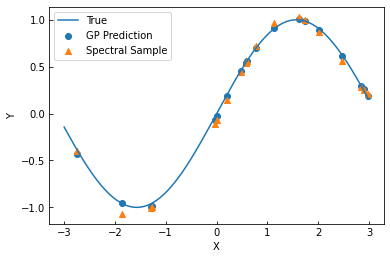

In [8]:
# X, Y, predict_Y, sample_Y = fit_and_sample()
fig, ax = plt.subplots(1)
ax.scatter(X[:,0], predict_Y[:, 0], marker= 'o', label='GP Prediction')
ax.scatter(X[:,0], sample_Y, marker='^', label= 'Spectral Sample')
ax.plot(X_true[:,0], Y_true[:,0], label='True')
ax.legend()
ax.tick_params(direction='in')
ax.set_xlabel('X')
_ = ax.set_ylabel('Y')

## Test points at different distances

In [98]:
def observed(X, noise_level=0.05):
    noise = rng.standard_normal([X.shape[0],1])*noise_level
    return np.sin(X) + noise

def gen_noisy_data(num_points=20, spacing=0.01):
    upper = -3 + num_points*spacing
    x = np.linspace(-3,upper,num_points)
    x = np.atleast_2d(x).T
    y = observed(X)
    return x, y

In [ ]:
m = GPyModel(input_dim=1)
spacings = [1e-5, 1e-4, 1e-3, 1e-2, 0.1]
inputs = []
outputs = []
sampled_fs = []
n_repeats = 20
for s in spacings:
    X, y = gen_noisy_data(spacing=s)
    m.fit(X, Y)
    repeats = []
    for i in range(n_repeats):
        try:
            f = m.spectral_sample(X, Y)
            repeats.append(f)
        except np.linalg.LinAlgError as e:
            repeats.append(e)
    sampled_fs.append(repeats)
    inputs.append(X)
    outputs.append(y)

In [113]:
num_errors = 0
for sample in sampled_fs:
    for r in sample:
        if not callable(r):
            num_errors += 1

In [114]:
num_errors

0